<a href="https://colab.research.google.com/github/anbaee/my-P.hD-Code/blob/master/Forex%20predict%20(LSTM%20Binary%20classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def preprocess_df(df):
    df = df.drop("future", 1)  # don't need this anymore.
    
    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] =[float(e) for e in df[col]]
            df[col] = df[col].pct_change()  # pct changefor  "normalizes"
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.
    
    df.dropna(inplace=True)  # cleanup again... jic.
    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    
    random.shuffle(sequential_data)  # shuffle for good measure.
    

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)


    
    return np.array(X), y  # return X and y...and make X a numpy array!

In [178]:
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing

SEQ_LEN = 10 # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "EUR-USD"


def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0


filename = 'EURUSDday.csv'
dataset ='/content/gdrive/My Drive/market prediction codes/' + filename
main_df = pd.read_csv(dataset )  # read in specific file
main_df['timestamp'] = main_df['date']+' '+ main_df['time']

main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df = main_df.sort_values('timestamp', axis = 0  )
main_df = main_df.set_index('timestamp')
main_df = main_df.drop('date' ,1)
main_df  = main_df.drop('time',1)


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
main_df['future'] = main_df['close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df['close'], main_df['future']))
#test and train seprate
dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.2*len(dates))]  # get the last 5% of the times

validation_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%
print(main_df.head())
print(main_df.describe())

               open     high      low    close  volume   future  target
timestamp                                                              
2012-05-31  1.23658  1.24281  1.23367  1.23649   75292  1.24328       1
2012-06-01  1.23650  1.24481  1.22881  1.24328   82401  1.24993       1
2012-06-04  1.24161  1.25093  1.23856  1.24993   60992  1.24517       0
2012-06-05  1.24992  1.25418  1.24098  1.24517   68668  1.25816       1
2012-06-06  1.24518  1.25850  1.24405  1.25816   76616  1.25599       0
              open         high  ...       future       target
count  1647.000000  1647.000000  ...  1647.000000  1647.000000
mean      1.206206     1.210915  ...     1.206159     0.496661
std       0.102335     0.101908  ...     0.102320     0.500141
min       1.038830     1.041780  ...     1.038820     0.000000
25%       1.117625     1.122055  ...     1.117815     0.000000
50%       1.181120     1.184850  ...     1.180760     0.000000
75%       1.301480     1.307510  ...     1.302015     1

In [0]:

train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)


In [180]:
print(train_x.shape)
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

(1618, 10, 5)
train data: 1618 validation: 378
Dont buys: 809, buys: 809
VALIDATION Dont buys: 189, buys: 189


In [0]:
import time

EPOCHS = 30  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization

In [0]:

model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.


model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))


In [184]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 128)           68608     
_________________________________________________________________
dropout_42 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 10, 128)           512       
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 32)              

In [185]:
history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, np.array(validation_y)))

Epoch 1/30
26/26 [==============================] - 1s 31ms/step - loss: 10.4713 - accuracy: 0.2361 - val_loss: 2.1573 - val_accuracy: 0.4206
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 9.5809 - accuracy: 0.3368 - val_loss: 2.6906 - val_accuracy: 0.4762
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 8.6737 - accuracy: 0.3375 - val_loss: 2.6903 - val_accuracy: 0.4762
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 6.3318 - accuracy: 0.3405 - val_loss: 2.4569 - val_accuracy: 0.4788
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 4.7120 - accuracy: 0.3906 - val_loss: 2.9890 - val_accuracy: 0.4947
Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 4.4764 - accuracy: 0.4061 - val_loss: 3.0832 - val_accuracy: 0.5000
Epoch 7/30
26/26 [==============================] - 0s 7ms/step - loss: 4.2458 - accuracy: 0.4221 - val_loss: 3.0213 - val_accuracy: 0.4735
Epoch 8/30
26/26 [

In [186]:
score = model.evaluate(validation_x, np.array(validation_y), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.5337722301483154
Test accuracy: 0.48677247762680054


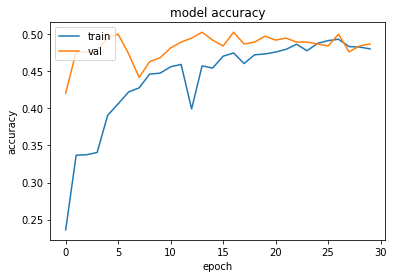

In [187]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

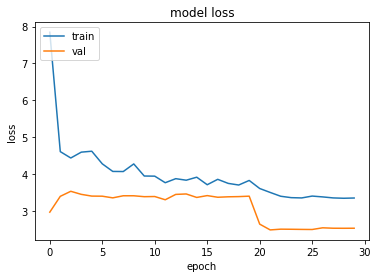

In [176]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()